# Cleveland Dot plot for capacity and energy representation

for the French power system

PH, Oct 2019


Some references on Dot Plots, apart from Cleveland book [The Elements of Graphing Data](https://www.goodreads.com/book/show/18619.Elements_of_Graphing_Data):

* “Cleveland (Dot Plot) Rocks! (with Tableau)”
https://spencerbaucke.com/2019/09/12/cleveland-dot-plot-rocks/

* UC Business Analytics R Programming Guide, “Cleveland Dot Plots” page
http://uc-r.github.io/cleveland-dot-plots

* https://www.jstor.org/stable/2288400
Graphical Perception: Theory, Experimentation, and Application to the Development of Graphical Methods
William S. Cleveland and Robert McGill
Journal of the American Statistical Association
Vol. 79, No. 387 (Sep., 1984), pp. 531-554 

In [1]:
import numpy as np
from numpy import log2, nan

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
%matplotlib inline

## For one single year

Read eCO2mix data (adapted from [RTE_explore_concat.ipynb](RTE_explore_concat.ipynb) Notebook)

In [2]:
columns_FR = [
    'Consommation',
    'Fioul', 'Charbon', 'Gaz', 'Nucléaire',
    'Eolien', 'Solaire',
    'Hydraulique', 'Pompage', 'Bioénergies',
    'Ech. physiques',
]

Translation of column names

In [3]:
columns = [
    'Load',
    'Oil', 'Coal', 'Gas', 'Nuclear',
    'Wind', 'Solar',
    'Hydro', 'Pump', 'Bio',
    'Exchanges',
]

In [4]:
def read_eCO2mix(fname, columns):
    """read eCO2mix data file. keep only `columns`"""
    df = pd.read_csv(fname, compression='xz', encoding='windows-1252',
                 sep='\t', skipfooter=2,engine='python',
                 index_col=False, parse_dates={'date':[2,3]})
    # keep only data at 30 min step
    df = df.iloc[::2,:]
    # set date as the index
    df.set_index('date', verify_integrity=True, inplace=True)
    df.index.name = ''
    # select columns
    return df.loc[:, columns]

### Read year 2017 as an example

Read only the main columns (not the detailed ones)

In [5]:
df = read_eCO2mix('data/eCO2mix_RTE_Annuel-Definitif_2017.xls.xz', columns_FR)
# translate names:
df = df.rename(dict(zip(columns_FR, columns)), axis=1)

df.tail(3)

,Load,Oil,Coal,Gas,Nuclear,Wind,Solar,Hydro,Pump,Bio,Exchanges
,,,,,,,,,,,
2017-12-31 22:30:00,57239.0,164.0,37.0,2447.0,42271.0,10698.0,-1.0,6845.0,-1937.0,1171.0,-4456.0
2017-12-31 23:00:00,60642.0,164.0,37.0,2450.0,42718.0,10712.0,-1.0,8353.0,-1186.0,1161.0,-3766.0
2017-12-31 23:30:00,60479.0,165.0,37.0,2464.0,42064.0,10720.0,-1.0,7712.0,-1052.0,1163.0,-2793.0


### Pre-processing RTE data

The problem lies with negative values:
* **Pump** is always negative
* **Exchanges** is negative and positive

In [6]:
df.Pump.min(), df.Pump.max()

(-3595.0, -3.0)

In [7]:
df.Exchanges.min(), df.Exchanges.max()

(-17230.0, 10011.0)

#### Splitting exchanges

For physical exchanges: split into two positive variables: Import and Export

In [9]:
pos = lambda x:  x if x >= 0 else 0
neg = lambda x: -x if x  < 0 else 0

In [10]:
df['Import'] = df['Exchanges'].map(pos)
df['Export'] = df['Exchanges'].map(neg)

In [11]:
del df['Exchanges']

#### Flipping pumped hydro power

For pumped hydro: flip the sign

In [12]:
df.Pump *= -1

#### Residual negative values

negative values are probably the self-consumption of Coal and Solar

In [13]:
(df < 0).sum()

Load          0
Oil           0
Coal       1342
Gas           0
Nuclear       0
Wind          0
Solar      8279
Hydro         0
Pump          0
Bio           0
Import        0
Export        0
dtype: int64

In [14]:
df.Solar.describe()

count    17520.000000
mean      1026.673402
std       1452.396534
min         -2.000000
25%         -1.000000
50%         14.000000
75%       1917.000000
max       5528.000000
Name: Solar, dtype: float64

In [15]:
df.Coal.describe()

count    17520.00000
mean      1111.32911
std        839.51716
min        -67.00000
25%        362.00000
50%       1051.00000
75%       1831.00000
max       2951.00000
Name: Coal, dtype: float64

#### Conversion MW → GW

In [16]:
df /= 1000

### Statistical Aggregation

#### Average and Max
* mean power
* max power (i.e. a proxy for the capacity)

In [17]:
stats = pd.DataFrame(data={'avg': df.mean(), 'max': df.max()})

#### Sort by max

sort by mean could be also interesting

In [18]:
stats.sort_values('max', inplace=True)
stats

,avg,max
Bio,1.077469,1.364
Coal,1.111329,2.951
Pump,0.817413,3.595
Oil,0.397095,4.231
Solar,1.026673,5.528
Gas,4.513795,9.583
Import,0.415179,10.011
Wind,2.750865,11.249
Hydro,6.051790,14.954
Export,5.093133,17.230


#### Off times

Some plants spend a significant fraction of the year with *close to zero production*.
This is visible on a cumulated histogram of normalized power

In [42]:
df_norm = df / df.max() # production scaled to the max.

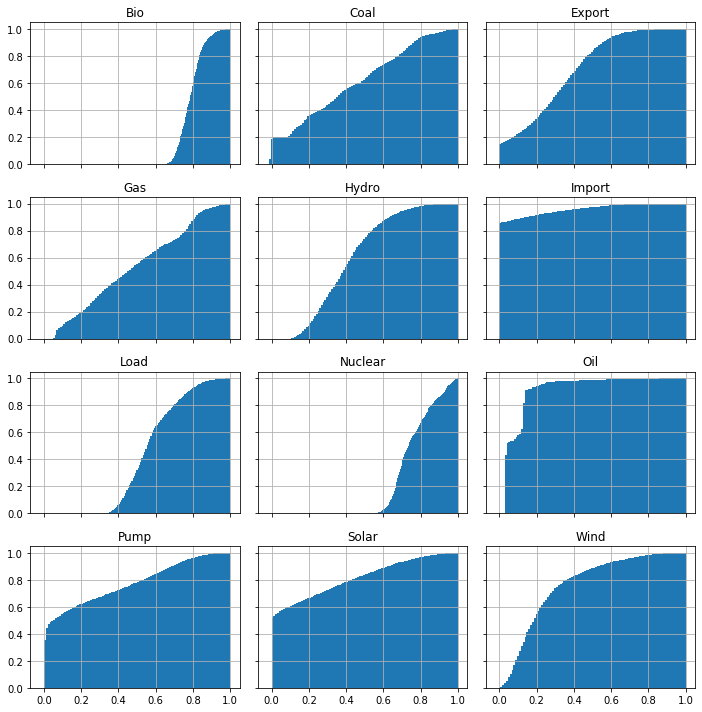

In [41]:
df_norm.hist(cumulative=True, density=True, bins=100,
        figsize=(10,10), sharex=True, sharey=True)
plt.tight_layout()

Average off time:

apart for wind, the off time is significant

In [52]:
df_zero = df_norm<0.01
stat_off = df_zero.mean()
stat_off[stat_off > 0]

Coal      0.186644
Wind      0.001427
Solar     0.520833
Pump      0.346290
Import    0.859018
Export    0.150228
dtype: float64

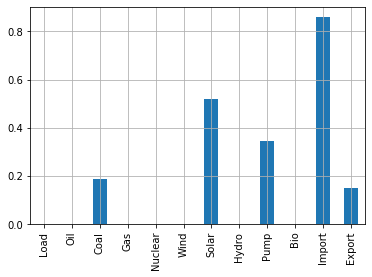

In [50]:
stat_off.plot.bar()
plt.grid()

Appending the off time statistic

In [55]:
stats['off'] = stat_off
stats.head(3)

,avg,max,off
Bio,1.077469,1.364,0.000000
Coal,1.111329,2.951,0.186644
Pump,0.817413,3.595,0.346290


#### Quantiles for non zero values

comparing with and without removal of zero values

In [59]:
df_norm.quantile(0.1)

Load       0.422905
Oil        0.031435
Coal       0.000678
Gas        0.107263
Nuclear    0.643525
Wind       0.063383
Solar     -0.000181
Hydro      0.203424
Pump       0.001947
Bio        0.714809
Import     0.000000
Export     0.000000
Name: 0.1, dtype: float64

In [58]:
df_norm[~df_zero].quantile(0.1)

Load       0.422905
Oil        0.031435
Coal       0.133853
Gas        0.107263
Nuclear    0.643525
Wind       0.063739
Solar      0.053148
Hydro      0.203424
Pump       0.016412
Bio        0.714809
Import     0.054430
Export     0.115485
Name: 0.1, dtype: float64

In [63]:
q_list = [0.05, 0.25, 0.75, 0.95]
stats_q = df[~df_zero].quantile(q_list)
stats_q

,Load,Oil,Coal,Gas,Nuclear,Wind,Solar,Hydro,Pump,Bio,Import,Export
0.05,37.43085,0.130,0.333,0.69000,35.36000,0.5060,0.1530,2.54895,0.048,0.954,0.32800,1.23135
0.25,45.21900,0.143,0.729,2.40100,38.54675,1.2230,0.9010,4.11300,0.226,1.017,1.25050,3.80275
0.75,63.06950,0.561,2.002,7.00425,47.59150,3.5390,3.2350,7.59150,2.144,1.129,4.38475,8.06500
0.95,78.30445,0.943,2.515,8.25700,54.43410,7.5753,4.6504,10.68415,2.961,1.226,6.61865,10.87765


Appending to the main `stat` DataFrame

In [73]:
for q in stats_q.index:
    q_name = f'q{100*q:02.0f}' # ex: 'q25'
    stats[q_name] = stats_q.loc[q]

stats.head(3)

,avg,max,off,q05,q25,q75,q95
Bio,1.077469,1.364,0.000000,0.954,1.017,1.129,1.226
Coal,1.111329,2.951,0.186644,0.333,0.729,2.002,2.515
Pump,0.817413,3.595,0.346290,0.048,0.226,2.144,2.961


### Dot plot for a single period

Color and marker for max and avg stat:

In [151]:
smarkers = {
    'avg': 'o',
    'max': '^'}

scolors = {
    'avg': 'tab:blue',
    'max': 'tab:red'}

Highlight range values for which the off time is significant:

In [149]:
# Color highlight
gray = (0.7,)*3
rgray = (0.9, 0.75, 0.75) # reddish gray

def qcolor(stats):
    'color list for quantile range lines'
    return [gray if stats.off[t] < 0.01 else rgray for t in stats.index]

def qls(stats):
    'line style lists for quantile range lines'
    return ['-' if stats.off[t] < 0.01 else '--' for t in stats.index]

qls(stats)

['-', '--', '--', '-', '--', '-', '--', '-', '-', '--', '-', '-']

Tweak the font:

In [150]:
#font_sans_default = plt.rcParams['font.sans-serif']
plt.rcParams['font.sans-serif'] = ['Lato']
# Fixes weights to 'medium' rather than 'normal' due to bug with Matplotlib 3.1.1
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['axes.labelweight'] = 'medium'
plt.rcParams['axes.titleweight'] = 'medium'
plt.rcParams['figure.titleweight'] = 'medium'

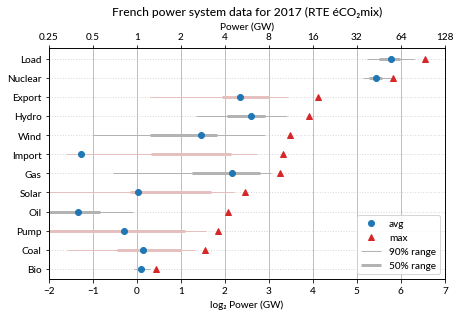

In [205]:
def dotplot_powersys(stats, period, suffix=''):
    """Cleveland dot plot for power system data of a single `period` (str)
    
    `stats` DataFrame should contain power system items as index
    and the following statistics as columns: max, avg, off, q05, q25, q75 and q95
    """
    fig, ax = plt.subplots(1,1, figsize=(6.5,4.5))

    # twin ax with shared scale
    # cf. @ImportanceOfBeingErnest at https://stackoverflow.com/questions/55907892/matplotlib-secondary-axis-with-values-mapped-from-primary-axis
    ax2 = ax.twiny()
    ax.get_shared_x_axes().join(ax, ax2)

    # Plot avg and max as dots
    for col in ['avg', 'max']:
        ax.plot(log2(stats[col]), stats.index, label=col,
                ls='', marker=smarkers[col], color=scolors[col])

    # Plot quantiles with lines
    ax.hlines(stats.index, log2(stats.q05), log2(stats.q95), label='90% range',
              lw=1, color=qcolor(stats), ls='-')
    ax.hlines(stats.index, log2(stats.q25), log2(stats.q75), label='50% range',
              lw=3, color=qcolor(stats), ls='-')


    ax.grid(axis='x', ls='-')
    ax.grid(axis='y', ls=':', lw=1, alpha=0.5)
    ax.set(
        xlabel='log₂ Power (GW)',
        xlim=(-2, 7),
        title=f'French power system data for {period} (RTE éCO₂mix)'
    )

    ax.legend(loc='lower right')

    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x,pos: f'{2**x:.4g}'))
    ax2.set_xlabel('Power (GW)')

    fig.tight_layout()
    fig.savefig(f'Dotplot_Powersys_{period}_{suffix}.png', dpi=300, bbox_inches='tight')

dotplot_powersys(stats, '2017', 'bymax')

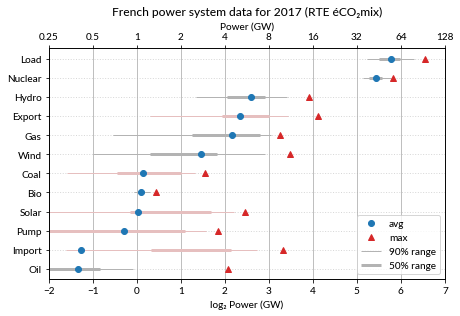

In [176]:
stats_byavg = stats.sort_values('avg')

dotplot_powersys(stats_byavg, '2017', 'byavg')

## Stats and plot for many years

### Stats for each available year

In [167]:
def preprocess(df):
    'preprocess RTE eCO2mix data before statistical aggregation'
    # translate names:
    df = df.rename(dict(zip(columns_FR, columns)), axis=1)

    # Sign flip for pumped hydro
    df.Pump *= -1
    
    # Split of imports and exports
    pos = lambda x:  x if x >= 0 else 0
    neg = lambda x: -x if x  < 0 else 0
    
    df['Import'] = df['Exchanges'].map(pos)
    df['Export'] = df['Exchanges'].map(neg)
    
    del df['Exchanges']
    
    # MW → GW
    df /= 1000
    
    return df

In [168]:
def power_stats(year):
    df = read_eCO2mix(f'data/eCO2mix_RTE_Annuel-Definitif_{year}.xls.xz', columns_FR)
    
    df = preprocess(df)
    
    # Mean and max
    stats = pd.DataFrame(data={'avg': df.mean(), 'max': df.max()})
    
    # Off time
    df_norm = df / df.max()
    df_zero = df_norm<0.01
    stat_off = df_zero.mean()
    stats['off'] = stat_off
    
    # Quantiles for nonzero values
    q_list = [0.05, 0.25, 0.75, 0.95]
    stats_q = df[~df_zero].quantile(q_list)
    
    for q in stats_q.index:
        q_name = f'q{100*q:02.0f}' # ex: 'q25'
        stats[q_name] = stats_q.loc[q]
    
    return stats

Compute the stats for each year (takes some seconds…)

In [169]:
stats_y = {y: power_stats(y) for y in range(2012, 2019)}

Concat the yearly stats (create a multi index)

In [170]:
stats_y = pd.concat(stats_y, axis=1)

**Sort**: by max of last year (2018)

In [171]:
stats_y.sort_values((2018,'max'), inplace=True)
stats_y

2012                                                             \
               avg      max       off       q05       q25       q75       q95   
Bio       0.664442    0.799  0.000000   0.56200   0.62400   0.71100   0.74700   
Oil       0.517325    5.926  0.000000   0.27600   0.29500   0.49200   1.09800   
Coal      1.986089    5.436  0.142304   0.35300   1.25300   3.28800   4.52765   
Pump      0.763865    3.376  0.420936   0.04800   0.36300   2.18600   2.92600   
Solar     0.430648    2.489  0.520719   0.06400   0.36100   1.36400   1.97005   
Import    0.146497    9.289  0.948372   0.26380   1.04550   4.33450   6.81300   
Gas       2.850610    8.625  0.000000   0.59100   0.82600   3.96000   7.50800   
Wind      1.696575    6.198  0.000683   0.32600   0.77475   2.32400   4.22850   
Export    5.400491   13.594  0.055499   1.61960   3.92100   7.43500  10.01240   
Hydro     7.213284   16.380  0.000000   3.33000   5.13900   9.06025  12.01930   
Nuclear  46.055824   60.811  0.000000  35.80600  39.45575  52.37925  58.93565   
Load     55.396962  102.098  0.000000  37.56035  45.90450  63.31200  80.30840   

              2013                    ...      2017                      \
               avg     max       off  ...       q25       q75       q95   
Bio       0.707971   0.835  0.000000  ...   1.01700   1.12900   1.22600   
Oil       0.453910   3.914  0.000000  ...   0.14300   0.56100   0.94300   
Coal      2.251811   6.265  0.159874  ...   0.72900   2.00200   2.51500   
Pump      0.821367   3.637  0.400970  ...   0.22600   2.14400   2.96100   
Solar     0.519008   2.950  0.521918  ...   0.90100   3.23500   4.65040   
Import    0.087988   4.930  0.938813  ...   1.25050   4.38475   6.61865   
Gas       2.282787   8.329  0.000000  ...   2.40100   7.00425   8.25700   
Wind      1.816477   6.531  0.000571  ...   1.22300   3.53900   7.57530   
Export    5.694872  13.198  0.067352  ...   3.80275   8.06500  10.87765   
Hydro     8.521735  16.805  0.000000  ...   4.11300   7.59150  10.68415   
Nuclear  46.058161  59.107  0.000000  ...  38.54675  47.59150  54.43410   
Load     56.185530  92.629  0.000000  ...  45.21900  63.06950  78.30445   

              2018                                                            
               avg     max       off       q05       q25       q75       q95  
Bio       1.089724   1.286  0.000000   0.98200   1.04200   1.13200   1.20200  
Oil       0.234531   2.507  0.000057   0.07300   0.08400   0.47600   0.55700  
Coal      0.656297   2.931  0.293265   0.31900   0.51800   1.18400   1.95200  
Pump      0.844762   3.651  0.350342   0.05000   0.18100   2.26100   3.08900  
Solar     1.208082   6.430  0.519692   0.17400   0.97200   3.87450   5.60930  
Import    0.109121   9.574  0.956849   0.25925   0.88825   3.78700   6.22575  
Gas       3.446567   9.700  0.000000   0.52300   1.18800   4.85400   8.10805  
Wind      3.211288  12.287  0.000742   0.54430   1.33800   4.38300   8.71700  
Export    7.383905  16.577  0.047432   1.97740   5.26000  10.32900  13.22200  
Hydro     7.695196  17.434  0.000000   2.89700   5.18775   9.90925  12.66715  
Nuclear  44.861127  58.640  0.000000  35.73270  40.44075  49.87925  56.46905  
Load     54.283220  96.272  0.000000  36.98195  44.92975  63.06900  75.99780  

[12 rows x 49 columns]

### Multi year plots

#### Off times over the years

TO BE DONE

#### Multi year dot plot

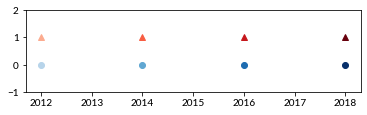

In [195]:
def scolor(year, years, stat, am=0.3, aM=1.0):
    """color for a symbol of a given year, for a given stat (avg or max)
    
    Color is taken by evaluating a colormap linearly on years,
    between lower value am and upper value aM.
    """
    ym = min(years)
    yM = max(years)
    
    if yM>ym:
        a = (year - ym)/(yM-ym) # in [0,1]
        a = am + a*(aM-am) # in [am, aM]
    else:
        a = 0.7
    if stat == 'avg':
        color = cm.Blues(a)
    elif stat == 'max':
        color = cm.Reds(a)
    return color

# Demo
years = [2012, 2014, 2016, 2018]
plt.figure(figsize=(6,1.5))
plt.ylim(-1,2)
for y in years:
    plt.plot(y, 0, 'o', color=scolor(y, years, 'avg'))
    plt.plot(y, 1, '^', color=scolor(y, years, 'max'))

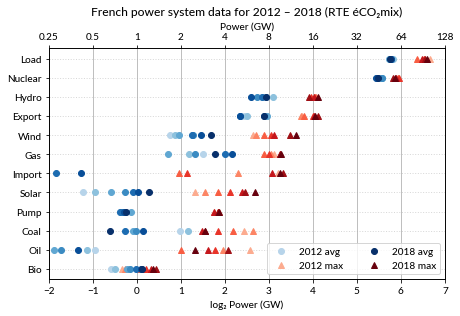

In [206]:
def dotplot_powersys_multi(stats_y, years, am=0.3, aM=1.0 ):
    """Cleveland dot plot for power system data over multiple `years` (list)
    
    `stats` DataFrame should contain power system items as index
    and the following statistics as columns: max, avg
    """
    fig, ax = plt.subplots(1,1, figsize=(6.5,4.5))
    
    # twin ax with shared scale
    # cf. @ImportanceOfBeingErnest at https://stackoverflow.com/questions/55907892/matplotlib-secondary-axis-with-values-mapped-from-primary-axis
    ax2 = ax.twiny()
    ax.get_shared_x_axes().join(ax, ax2)

    # Plot avg and max as dots
    for year in years:
        for s in ['avg', 'max']:
            col = (year, s)
            
            color = scolor(year, years, s, am, aM)
            
            # label only first and last year:
            label = f'{year} {s}'  if year == years[0] or year == years[-1] else ''
            
            ax.plot(log2(stats_y[col]), stats_y.index, label=label,
                    ls='', marker=markers[s], color=color)

    ax.grid(axis='x', ls='-')
    ax.grid(axis='y', ls=':', lw=1, alpha=0.5)
    period = f'{years[0]} – {years[-1]}' if years[0] !=  years[-1] else f'{years[0]}'
    ax.set(
        xlabel='log₂ Power (GW)',
        xlim=(-2, 7),
        title=f'French power system data for {period} (RTE éCO₂mix)'
    )
    ax.locator_params('x', nbins=10)
    
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x,pos: f'{2**x:.4g}'))
    ax2.set_xlabel('Power (GW)')
    
    ncol = 2 if years[0] !=  years[-1] else 1
    ax.legend(loc='lower right', ncol=ncol)

    fig.tight_layout() # rect=(0,0.1,1,1) for when the legend is on the figure
    years_txt = '20' + '-'.join(str(y)[2:] for y in years)
    fig.savefig(f'Dotplot_Powersys_{years_txt}.png', dpi=300, bbox_inches='tight')

dotplot_powersys_multi(stats_y, range(2012, 2019))

Plot only first and last year:

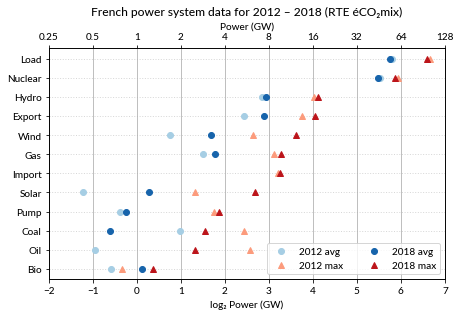

In [207]:
dotplot_powersys_multi(stats_y, [2012, 2018], am=0.35, aM=0.8)

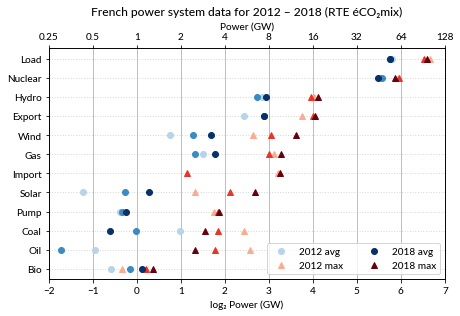

In [208]:
dotplot_powersys_multi(stats_y, [2012, 2015, 2018])

Generate the individual plot for each year

In [202]:
stats_y[2012]

,avg,max,off,q05,q25,q75,q95
Bio,0.664442,0.799,0.000000,0.56200,0.62400,0.71100,0.74700
Oil,0.517325,5.926,0.000000,0.27600,0.29500,0.49200,1.09800
Coal,1.986089,5.436,0.142304,0.35300,1.25300,3.28800,4.52765
Pump,0.763865,3.376,0.420936,0.04800,0.36300,2.18600,2.92600
Solar,0.430648,2.489,0.520719,0.06400,0.36100,1.36400,1.97005
Import,0.146497,9.289,0.948372,0.26380,1.04550,4.33450,6.81300
Gas,2.850610,8.625,0.000000,0.59100,0.82600,3.96000,7.50800
Wind,1.696575,6.198,0.000683,0.32600,0.77475,2.32400,4.22850
Export,5.400491,13.594,0.055499,1.61960,3.92100,7.43500,10.01240
Hydro,7.213284,16.380,0.000000,3.33000,5.13900,9.06025,12.01930


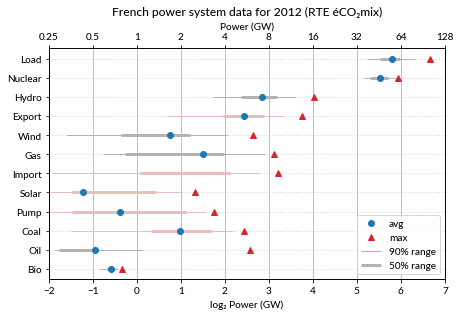

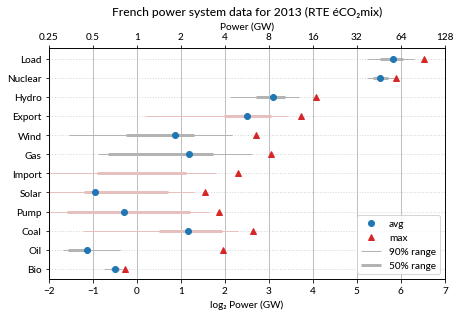

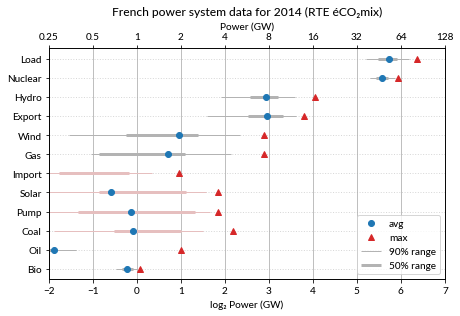

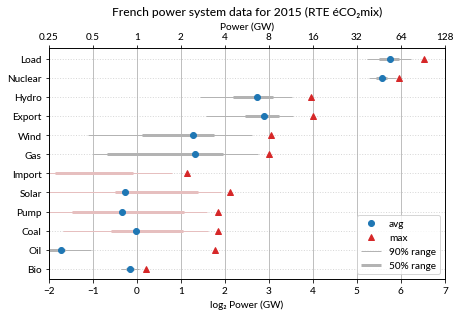

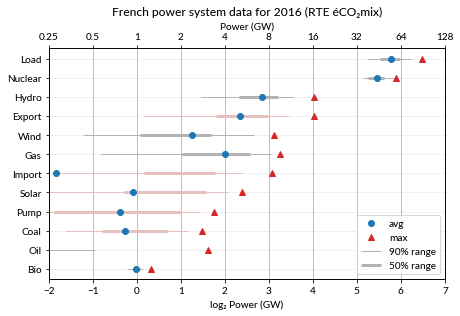

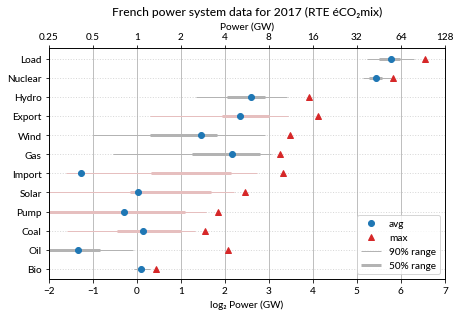

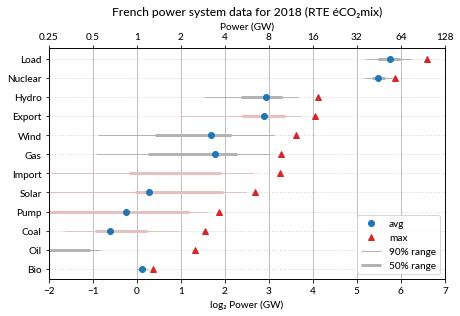

In [204]:
for year in range(2012, 2019):
    dotplot_powersys(stats_y[year], year, 'bymax2018')

## Plot with Altair

https://altair-viz.github.io/

In [209]:
import altair as alt

reshaping data to from wide to [long-form](https://altair-viz.github.io/user_guide/data.html#long-form-vs-wide-form-data) with `DataFrame.melt`:

In [220]:
stats_yl_full = stats_y.reset_index().melt('index', var_name=['year', 'stat'])
stats_yl_full.rename(columns={'index':'type'}, inplace=True)

# log2 transform
stats_yl_full['log2'] = np.log2(stats_yl.value)
stats_yl_full

,type,year,stat,value,log2
0,Bio,2012,avg,0.664442,-0.589785
1,Oil,2012,avg,0.517325,-0.950856
2,Coal,2012,avg,1.986089,0.989930
3,Pump,2012,avg,0.763865,-0.388610
4,Solar,2012,avg,0.430648,-1.215420
...,...,...,...,...,...
583,Wind,2018,q95,8.717000,3.123832
584,Export,2018,q95,13.222000,3.724869
585,Hydro,2018,q95,12.667150,3.663020
586,Nuclear,2018,q95,56.469050,5.819388


Rows with avg or max stat:

In [221]:
avg_max = (stats_yl_full.stat == 'avg') | (stats_yl_full.stat == 'max')
avg_max.sum()

168

In [222]:
stats_yl = stats_yl_full[avg_max]

short alias for the year column:

In [223]:
y = stats_yl.year

Use the same sorting as `stats_y`:

In [224]:
sorted_types = stats_y.index.values
sorted_types = list(sorted_types)
sorted_types.reverse()
print(sorted_types)

['Load', 'Nuclear', 'Hydro', 'Export', 'Wind', 'Gas', 'Import', 'Solar', 'Pump', 'Coal', 'Oil', 'Bio']


### Plot a single year

TODO: 
* find a better way to customize the color and the shape without breaking the legend → DONE

In [228]:
stats_yl[y==2018]

,type,year,stat,value,log2
504,Bio,2018,avg,1.089724,0.123963
505,Oil,2018,avg,0.234531,-2.092148
506,Coal,2018,avg,0.656297,-0.607579
507,Pump,2018,avg,0.844762,-0.243382
508,Solar,2018,avg,1.208082,0.272719
509,Import,2018,avg,0.109121,-3.196001
510,Gas,2018,avg,3.446567,1.785160
511,Wind,2018,avg,3.211288,1.683152
512,Export,2018,avg,7.383905,2.884384
513,Hydro,2018,avg,7.695196,2.943958


In [225]:
alt.themes.get()()

{'config': {'view': {'width': 400, 'height': 300}, 'mark': {'tooltip': None}}}

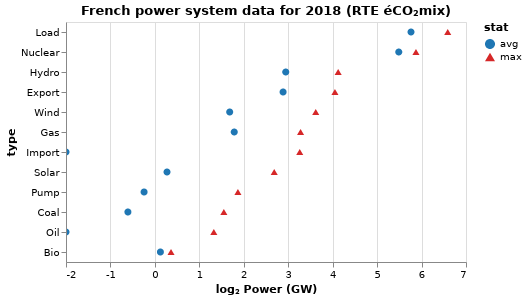

In [243]:
shape_scale = alt.Scale(domain=['avg', 'max'], range=['circle', 'triangle-up'])

tab_blue = '#1f77b4' # ( 31, 119, 180)
tab_red = '#d62728' # (214,  39,  40)
color_scale = alt.Scale(domain=['avg', 'max'], range=[tab_blue, tab_red])

alt.Chart(stats_yl[y==2018]).mark_point(filled=True, size=50, opacity=1).encode(
    x=alt.X('log2', 
        scale = alt.Scale(
            domain=(-2,7),
            clamp=True # nice for interactive charts. otherwise, clip=True may be better
        ),
        axis=alt.Axis(title='log₂ Power (GW)')
    ),
    y=alt.Y('type', sort=sorted_types),
    color=alt.Color('stat',
        scale=color_scale
    ),
    shape=alt.Shape(
        'stat', 
        scale=shape_scale
    ),
    tooltip=['year', 'value']
).properties(
    title='French power system data for 2018 (RTE éCO₂mix)'
).interactive()

### Plot all years

a bit confusing when the coloring function of years is not added

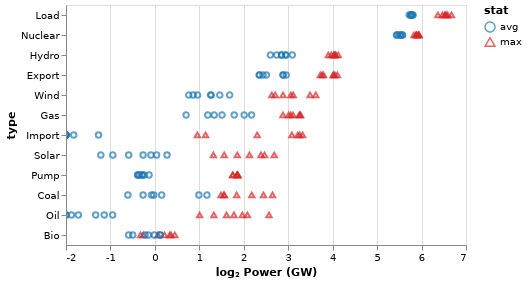

In [232]:
alt.Chart(stats_yl).mark_point().encode(
    x=alt.X('log2', 
        scale = alt.Scale(
            domain=(-2,7),
            clamp=True # nice for interactive charts. otherwise, clip=True may be better
        ),
        axis=alt.Axis(title='log₂ Power (GW)')
    ),
    y=alt.Y('type', sort=sorted_types),
    color=alt.Color('stat',
        scale=color_scale
    ),
    shape=alt.Shape(
        'stat', 
        scale=shape_scale
    ),
    tooltip=['year', 'value']
).interactive()

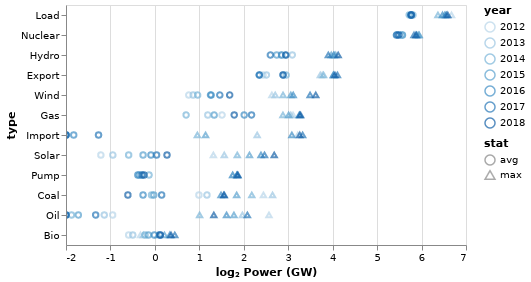

In [235]:
alt.Chart(stats_yl).mark_point().encode(
    x=alt.X('log2', 
        scale = alt.Scale(
            domain=(-2,7),
            clamp=True # nice for interactive charts. otherwise, clip=True may be better
        ),
        axis=alt.Axis(title='log₂ Power (GW)')
    ),
    y=alt.Y('type', sort=sorted_types),
    color='year:O',
    shape=alt.Shape(
        'stat', 
        scale=shape_scale
    ),
    tooltip=['year', 'value']
).interactive()

### All years - with interactive selection

TODO: try a layerd chart so that the selected points are drawn **over** the others

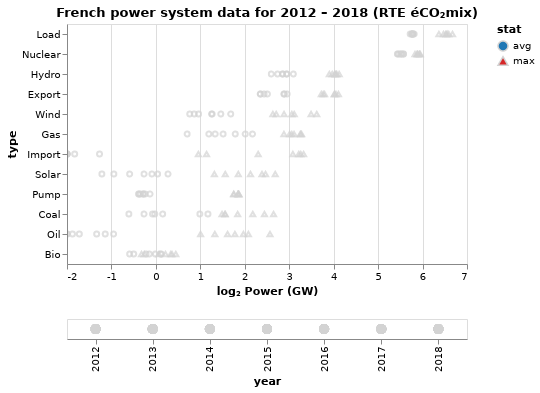

In [244]:
selector = alt.selection_single(
    fields=['year'],
    empty='none',
    on='mouseover',
    nearest=True
)

base = alt.Chart(stats_yl).properties(
    width=400,
).add_selection(selector)

# The Dot plot
values  = base.mark_point().encode(
    x=alt.X('log2', 
        scale = alt.Scale(
            domain=(-2,7),
            clamp=True # nice for interactive charts. otherwise, clip=True may be better
        ),
        axis=alt.Axis(title='log₂ Power (GW)')
    ),
    y=alt.Y('type', sort=sorted_types),
    shape=alt.Shape(
        'stat', 
        scale=shape_scale
    ),
    # Make color, size, etc... interactive
    fill=alt.condition(
        selector,
        alt.Color('stat:N',scale=color_scale),
        alt.value('lightgray')
    ),
    stroke=alt.condition(
        selector,
        alt.Color('stat:N',scale=color_scale),
        alt.value('lightgray')
    ),
    fillOpacity=alt.condition(selector,
                        alt.value(1),
                        alt.value(0)),
    opacity=alt.condition(selector,
                        alt.value(1),
                        alt.value(0.7)),
    size=alt.condition(selector,
                       alt.value(50),
                       alt.value(25)),
    tooltip=['year', 'value']
).properties(
    title='French power system data for 2012 – 2018 (RTE éCO₂mix)'
).interactive()

# Year selector
years = base.mark_point(filled=True, size=100).encode(
    x='year:O',
    color=alt.condition(selector,
                        alt.value('green'),
                        alt.value('lightgray')),
)

chart = values & years
chart

In [245]:
chart.save('Dotplot_Powersys_interactive.html')
chart.save('Dotplot_Powersys_interactive.json')